In [1]:
from pathlib import Path
import re

import numpy as np 
from scipy import stats
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm.auto as tqdm

In [2]:
df = pd.read_csv('/Users/harmanpreetsingh/Desktop/Housing.csv')

In [3]:
# Target variable
target = 'MEDV'

In [4]:
# Basic data exploration
print("Dataset Summary:")
print(df.describe())
print("\nData Types:")
print(df.dtypes)
print("\nDataset Information:")
print(df.info())
print("\nUnique Value Counts:")
print(df.nunique())

Dataset Summary:
             CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  509.000000  509.000000  506.000000  509.000000  507.000000  509.000000   
mean     3.707516   11.296660   11.198281    0.068762    0.555216    6.279845   
std      8.732089   23.269781    6.856713    0.253298    0.115633    0.703449   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082210    0.000000    5.190000    0.000000    0.449000    5.880000   
50%      0.261690    0.000000    9.690000    0.000000    0.538000    6.202000   
75%      3.693110   12.500000   18.100000    0.000000    0.624000    6.619000   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  508.000000  509.000000  508.000000  509.000000  509.000000  509.000000   
mean    68.579134    3.787705    9.610236  409.216110   18.463851  356.664892   
std     28

In [5]:
# Function to plot histograms of numerical features
def plot_hist(df):
    # Selecting numerical features
    numerical_cols = df.select_dtypes(include=[np.number]).columns

    ncols = 2
    nrows = int(np.ceil(len(numerical_cols) / ncols))
    
    vertical_figsize = 2 * nrows
    fig, axs = plt.subplots(nrows, ncols, figsize=(10, vertical_figsize), squeeze=False)
    
    axs = axs.flatten()

    for i, col in enumerate(numerical_cols):
        ax = axs[i]
        ax.hist(df[col], bins=20, color='skyblue', edgecolor='black')
        ax.set_title(col)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

  
    for ax in axs[len(numerical_cols):]:
        ax.axis('off')

    plt.tight_layout()
    plt.show()

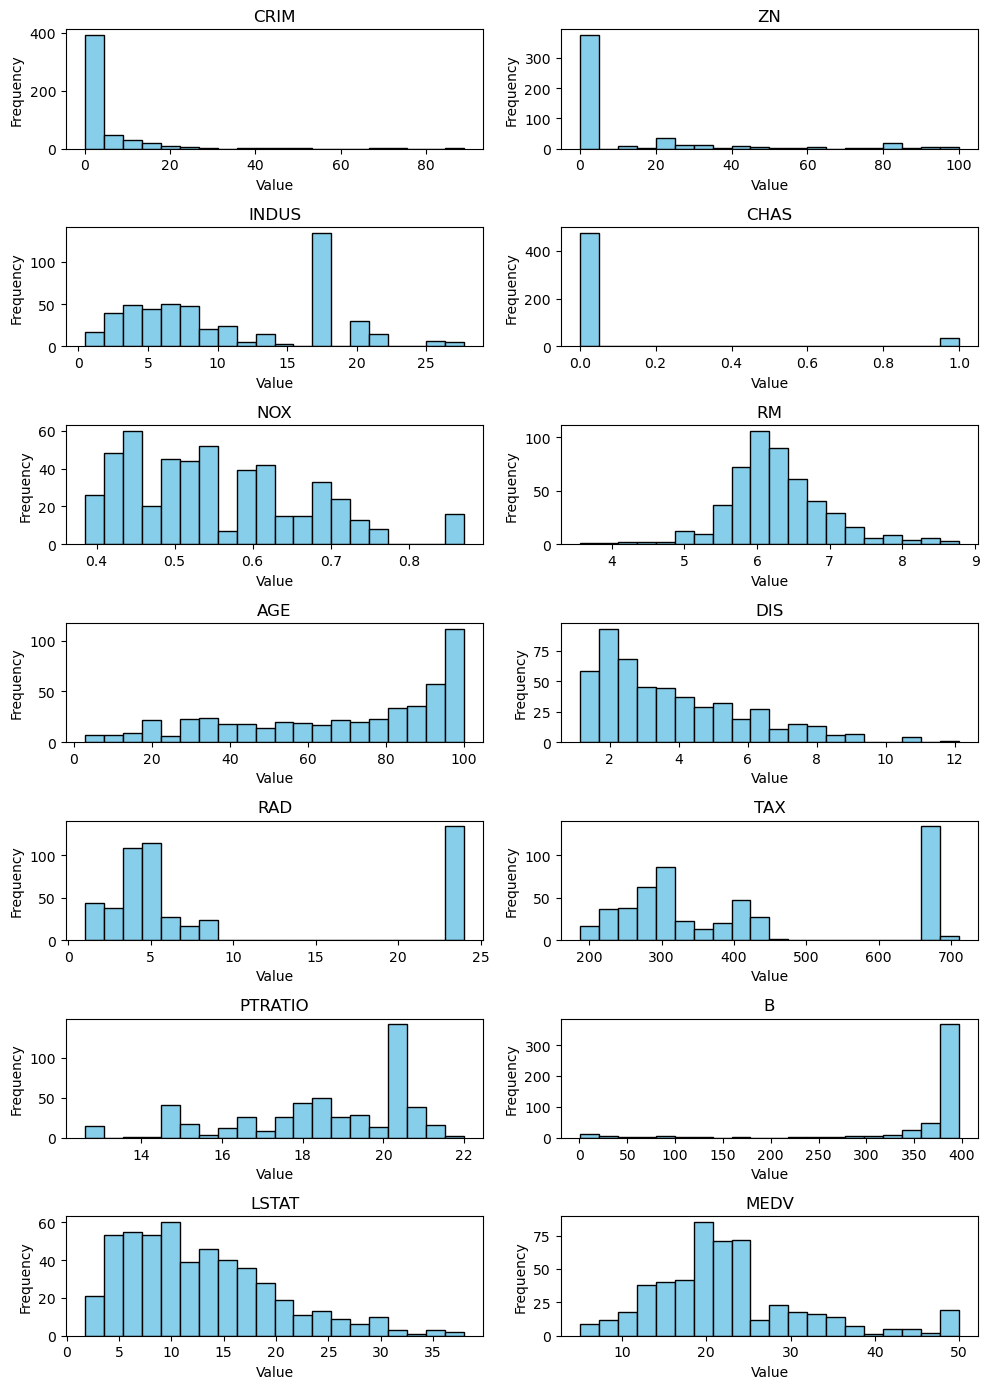

In [6]:
# Plot histograms of numerical features
plot_hist(df)

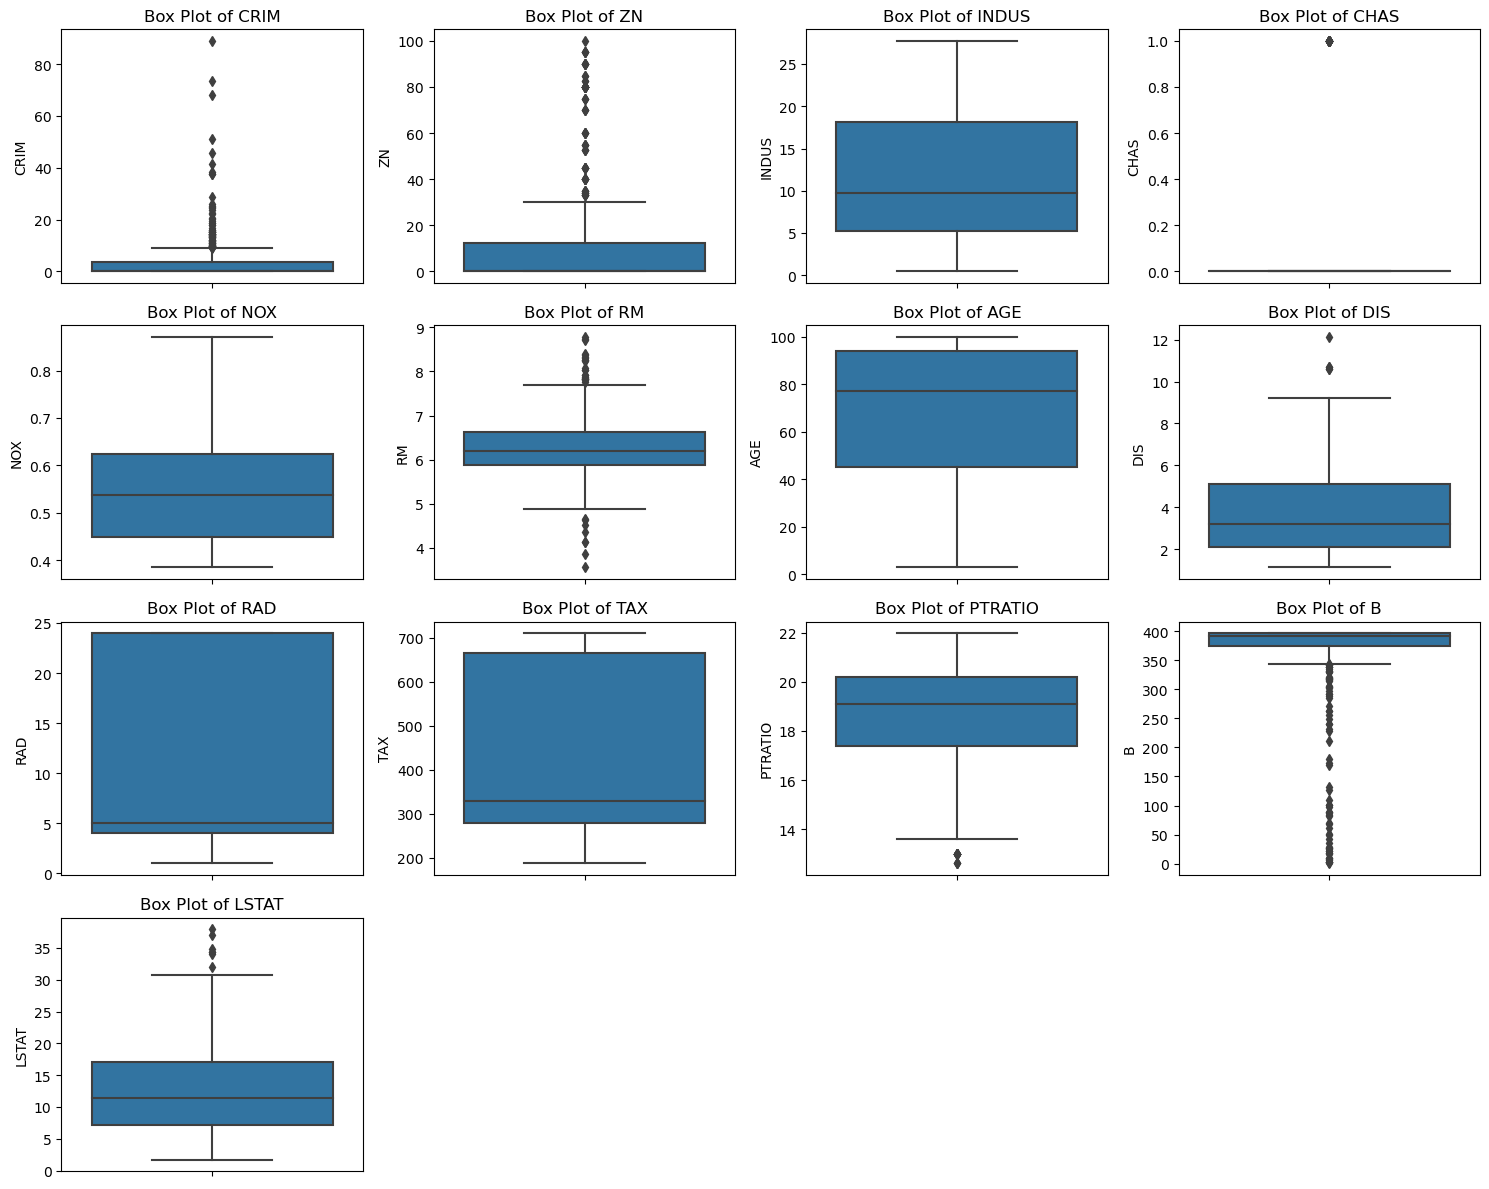

In [7]:
subset_columns = df.select_dtypes(include=[np.number]).columns[:-1]  # Select numerical columns except the target
num_features = len(subset_columns)
cols_per_row = 4 
rows_needed = (num_features + cols_per_row - 1) // cols_per_row  # Calculate rows needed

plt.figure(figsize=(15, rows_needed * 3)) 
for i, col in enumerate(subset_columns):
    plt.subplot(rows_needed, cols_per_row, i + 1)
    sns.boxplot(data=df, y=col)
    plt.title(f'Box Plot of {col}') 

plt.tight_layout()
plt.show()

In [8]:
# Calculating IQR for each column in the subset
Q1 = df[subset_columns].quantile(0.25)
Q3 = df[subset_columns].quantile(0.75)
IQR = Q3 - Q1

# Defining a mask to filter out outliers
outlier_mask = ((df[subset_columns] < (Q1 - 1.5 * IQR)) | (df[subset_columns] > (Q3 + 1.5 * IQR))).any(axis=1)

# Applying the mask to filter the DataFrame
df_filtered = df[~outlier_mask]

# Quantifying data loss
data_loss_percentage = 100 * (1 - len(df_filtered) / len(df))
print(f"Data retained after outlier removal: {100 - data_loss_percentage:.2f}%")


Data retained after outlier removal: 54.22%


In [10]:
# Handle missing values by replacing with median
df = df.fillna(df.median(axis=0))

In [11]:
# Convert 'CHAS' column to boolean type
df['CHAS'] = df['CHAS'].astype(bool)

In [12]:
# Create new features through feature engineering
df['CRIM_ZN'] = df['CRIM'] * df['ZN']
df['INDUS_CHAS'] = df['INDUS'] * df['CHAS']
df['NOX_DIS'] = df['NOX'] * df['DIS']
df['RM_AGE'] = df['RM'] * df['AGE']
df['RAD_TAX'] = df['RAD'] * df['TAX']
df['PTRATIO_B'] = df['PTRATIO'] * df['B']

In [13]:
def best_transformation(data) -> tuple:
    functions = [np.log1p, np.sqrt, stats.yeojohnson]
    results = []
    
    for func in functions:
        transformed_data = func(data)
        if type(transformed_data) == tuple:
            vals, _ = transformed_data
            results.append(vals)
        else:
            results.append(transformed_data)
            
    abs_skew_results = [np.abs(stats.skew(val)) for val in results]
    lowest_skew_index = abs_skew_results.index(min(abs_skew_results))
    return functions[lowest_skew_index], results[lowest_skew_index]

In [14]:
def unskew(col):
    global best_transformation
    print('-' * 100)
    col_skew = stats.skew(col)
    col_name = col.name
    print('{} skew is: {}'.format(col_name, col_skew))
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[10, 4])
    col.plot.hist(color='red', alpha=.4, label='pre-skew', ax=ax1)

    if np.abs(col_skew) >= 1.:
        result_skew, data = best_transformation(col)
        new_col_skew = stats.skew(data)
        print(f'Best function {result_skew} and the skew results: {new_col_skew}')
        ax2.hist(data, label='post skew processing')
        plt.legend()
        plt.show()
        
        if data is None:  # Check if data is None before performing further operations
            print(f'Transformation was not successful for {col_name}, returning original data')
            return col 
        
        if np.abs(new_col_skew) >= 1.:
            print(f'Transformation was not successful for {col_name}, returning original data')
            return col 
        
        return data 
    
    plt.show()

In [15]:
# Identify skewed columns and apply transformations
skew_res = df.select_dtypes([int, float]).skew().abs().sort_values(ascending=False)
skew_cols = skew_res.loc[(skew_res >= 1) & (skew_res.index != target)].index
print("\nColumns that are skewed:")
print(', '.join(skew_cols))


Columns that are skewed:
CRIM, INDUS_CHAS, CRIM_ZN, B, ZN, PTRATIO_B, RAD_TAX, DIS


----------------------------------------------------------------------------------------------------
CRIM skew is: 5.039268385290411
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 0.591919839543328


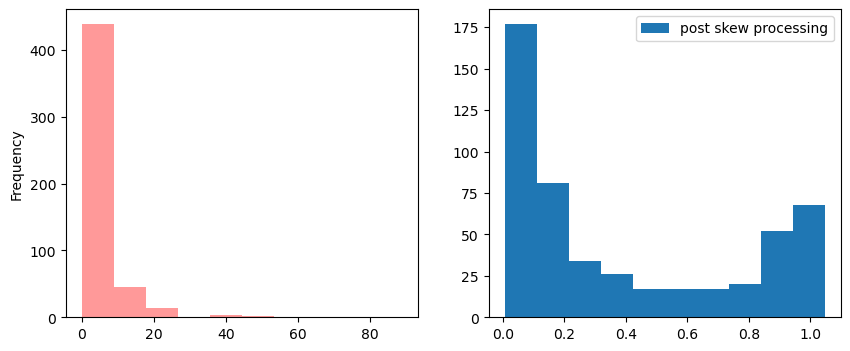

----------------------------------------------------------------------------------------------------
INDUS_CHAS skew is: 4.2958364268220945
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 3.4083448897268838


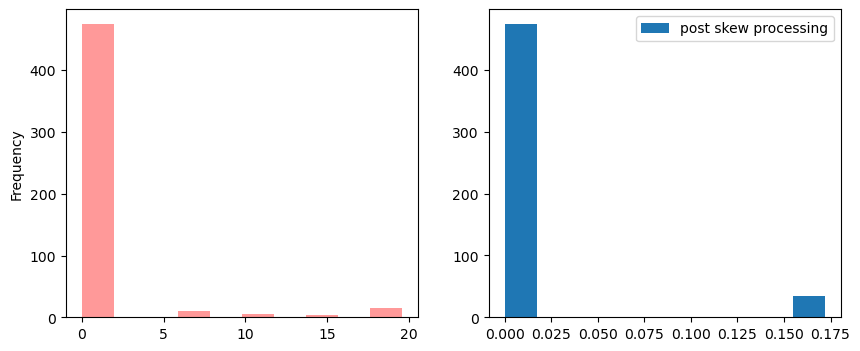

Transformation was not successful for INDUS_CHAS, returning original data
----------------------------------------------------------------------------------------------------
CRIM_ZN skew is: 3.8666200276645553
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 1.117940048429315


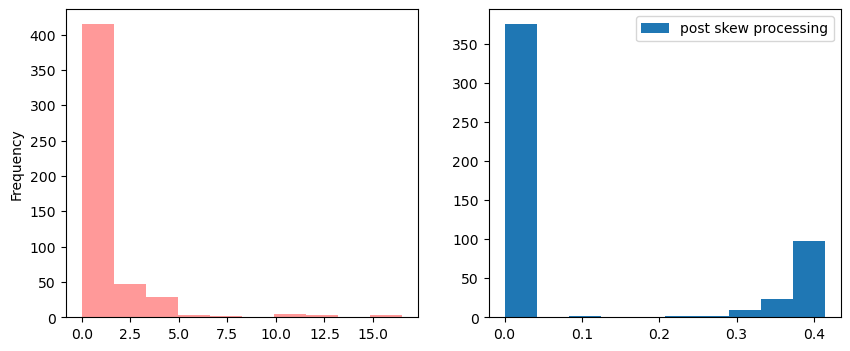

Transformation was not successful for CRIM_ZN, returning original data
----------------------------------------------------------------------------------------------------
B skew is: -2.8929901521077115
Best function <function yeojohnson at 0x1462ffd80> and the skew results: -1.912938918160781


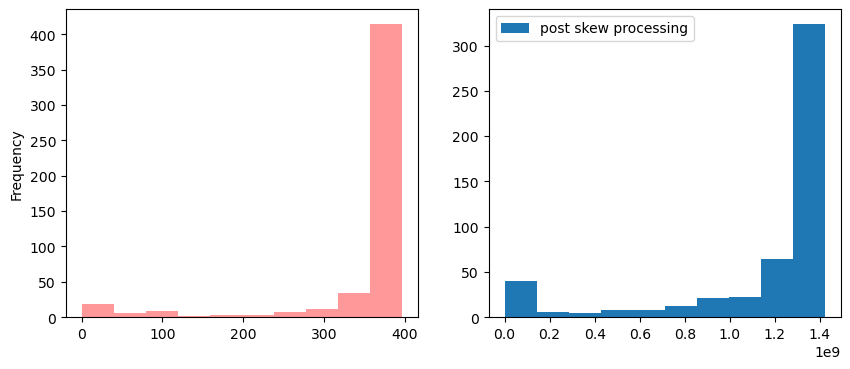

Transformation was not successful for B, returning original data
----------------------------------------------------------------------------------------------------
ZN skew is: 2.2289141017520993
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 1.0775267223714033


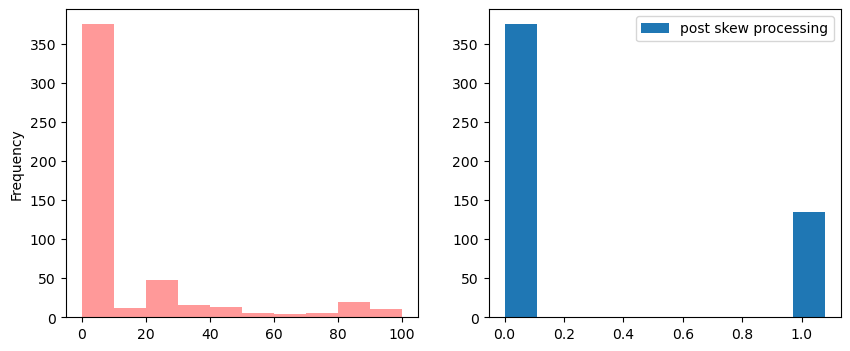

Transformation was not successful for ZN, returning original data
----------------------------------------------------------------------------------------------------
PTRATIO_B skew is: -2.067932021002207
Best function <function yeojohnson at 0x1462ffd80> and the skew results: -0.8972822949834165


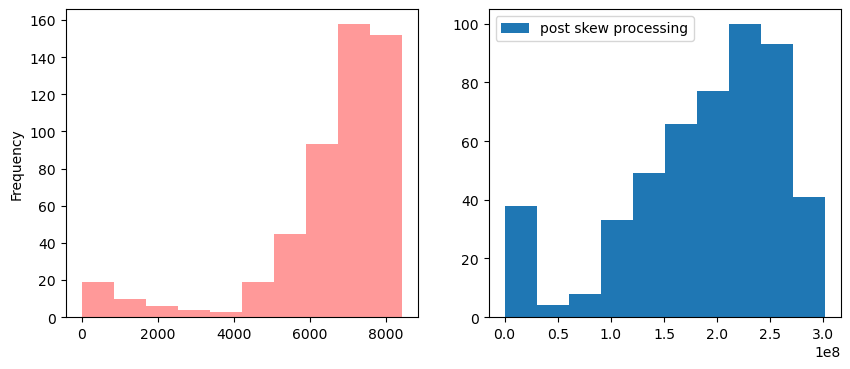

----------------------------------------------------------------------------------------------------
RAD_TAX skew is: 1.0496626140364416
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 0.06768725522055935


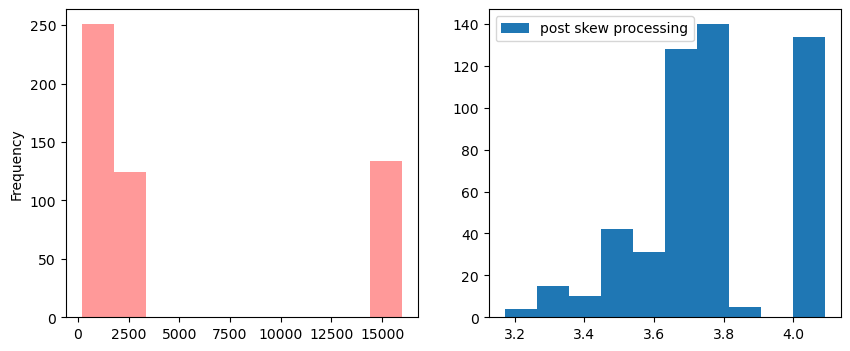

----------------------------------------------------------------------------------------------------
DIS skew is: 1.0172283893817673
Best function <function yeojohnson at 0x1462ffd80> and the skew results: 0.06811069535507755


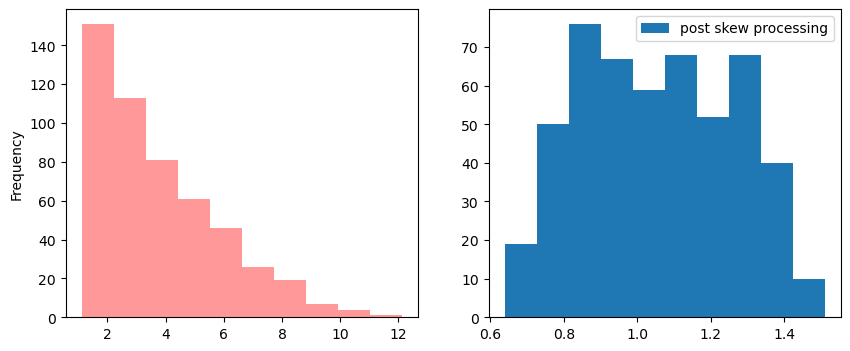

In [16]:
df[skew_cols] = df[skew_cols].apply(unskew, axis=0)


Chosen features based on correlation with target:
['B', 'CRIM_ZN', 'ZN', 'AGE', 'RAD', 'RAD_TAX', 'NOX', 'CRIM', 'TAX', 'INDUS', 'PTRATIO', 'RM', 'LSTAT']


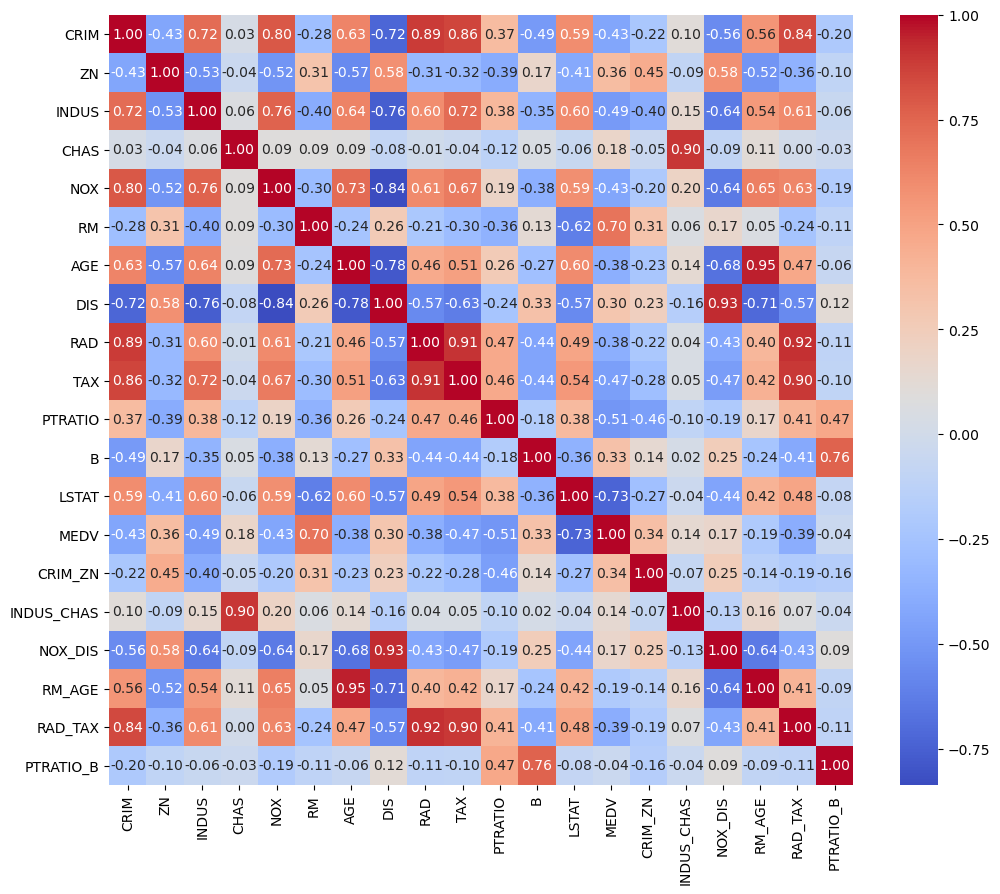

In [17]:
# Feature Selection
corr_ranking = df.drop(target, axis=1).corrwith(df[target]).abs().sort_values(ascending=True)
_, ax = plt.subplots(figsize=[12, 10])
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", cbar=True, ax=ax);

threshold = 0.3
chosen_cols = corr_ranking[corr_ranking >= threshold].index.to_list()
print("\nChosen features based on correlation with target:")
print(chosen_cols)

In [18]:
# Split data into features and target variable
X = df[chosen_cols]
y = df[target]

In [19]:
# Train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [20]:
# Scale the features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
cols = X_train.select_dtypes([float, int]).columns.to_list()
X_train[cols] = scaler.fit_transform(X_train)
X_test[cols] = scaler.transform(X_test)

In [21]:
# Model Construction
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [22]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grids for each model
param_grid_lr = {'fit_intercept': [True, False]}
param_grid_rf = {'n_estimators': [100, 200, 300], 'max_depth': [5, 10, 15], 'max_features': [5, 7, 9]}
param_grid_xgb = {'n_estimators': [200, 300, 400], 'max_depth': [3, 5, 7], 'learning_rate': [0.05, 0.1, 0.2]}

# Perform Grid Search with cross-validation for each model
grid_search_lr = GridSearchCV(LinearRegression(), param_grid_lr, cv=5, scoring='neg_mean_squared_error')
grid_search_rf = GridSearchCV(RandomForestRegressor(), param_grid_rf, cv=5, scoring='neg_mean_squared_error')
grid_search_xgb = GridSearchCV(XGBRegressor(), param_grid_xgb, cv=5, scoring='neg_mean_squared_error')

In [26]:
# Fit Grid Search to the data
grid_search_lr.fit(X_train, y_train)
grid_search_rf.fit(X_train, y_train)
grid_search_xgb.fit(X_train, y_train)

# Get best hyperparameters and models
best_params_lr = grid_search_lr.best_params_
best_model_lr = grid_search_lr.best_estimator_

best_params_rf = grid_search_rf.best_params_
best_model_rf = grid_search_rf.best_estimator_

best_params_xgb = grid_search_xgb.best_params_
best_model_xgb = grid_search_xgb.best_estimator_

# Print best hyperparameters for each model
print("Best Hyperparameters for Linear Regression:", best_params_lr)
print("Best Hyperparameters for Random Forest:", best_params_rf)
print("Best Hyperparameters for XGBoost:", best_params_xgb)

Best Hyperparameters for Linear Regression: {'fit_intercept': True}
Best Hyperparameters for Random Forest: {'max_depth': 10, 'max_features': 7, 'n_estimators': 300}
Best Hyperparameters for XGBoost: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}


In [31]:
from sklearn.metrics import mean_squared_error
# Evaluate best models on test set
lr_mse = mean_squared_error(y_test, best_model_lr.predict(X_test))
rf_mse = mean_squared_error(y_test, best_model_rf.predict(X_test))
xgb_mse = mean_squared_error(y_test, best_model_xgb.predict(X_test))

print("Test MSE for Linear Regression:", lr_mse)
print("Test MSE for Random Forest:", rf_mse)
print("Test MSE for XGBoost:", xgb_mse)

Test MSE for Linear Regression: 23.02343069138192
Test MSE for Random Forest: 7.523972270447332
Test MSE for XGBoost: 7.563140246214075


In [34]:
# Define the grid search parameters
best_model_params = {
    'LinearRegression': best_params_lr,
    'RandomForestRegressor': best_params_rf,
    'XGBRegressor': best_params_xgb
}

# Train models and evaluate on test set
model_results = []
for model_name, params in best_model_params.items():
    model = eval(model_name)()  # Create model instance
    model.set_params(**params)  # Set hyperparameters
    model.fit(X_train, y_train)  # Train model
    
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    results = pd.Series({'MSE': mse, 'RMSE': rmse, 'R2': r2}, name=model_name)
    model_results.append(results)

# Display model evaluation results
print("\nModel Evaluation Results:")
print(pd.concat(model_results, axis=1))



Model Evaluation Results:
      LinearRegression  RandomForestRegressor  XGBRegressor
MSE          23.023431               7.746475      7.563140
RMSE          4.798274               2.783249      2.750116
R2            0.673267               0.890067      0.892669


In [35]:
# Define best models
best_random_forest = RandomForestRegressor(**best_model_params['RandomForestRegressor'])
best_random_forest.fit(X_train, y_train)

xgb_model = XGBRegressor(**best_model_params['XGBRegressor'])
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [36]:
# Predicting with the models
random_forest_y_pred = best_random_forest.predict(X_test)
xgb_y_pred = xgb_model.predict(X_test)

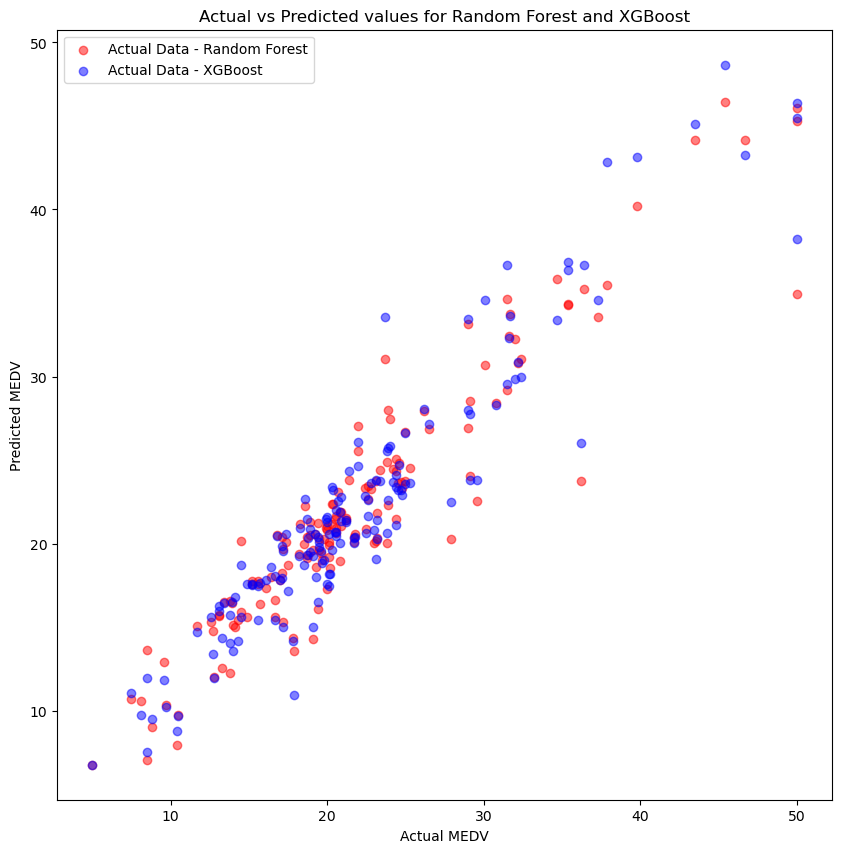

In [37]:
# Plotting actual vs predicted values for a specific feature
plt.figure(figsize=(10, 10))
plt.scatter(y_test, random_forest_y_pred, color='red', alpha=0.5, label='Actual Data - Random Forest')
plt.scatter(y_test, xgb_y_pred, color='blue', alpha=0.5, label='Actual Data - XGBoost')
plt.xlabel('Actual MEDV')
plt.ylabel('Predicted MEDV')
plt.legend()
plt.title('Actual vs Predicted values for Random Forest and XGBoost')
plt.show()

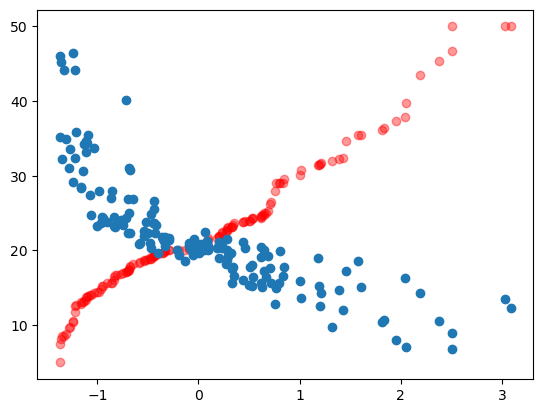

In [38]:
# Plot Random Forest predictions
col = 'LSTAT'
random_forest_y_pred = best_random_forest.predict(X_test.sort_values(by=col))
plt.scatter(X_test[col].sort_values(), y_test[X_test.index].sort_values(), color='red', alpha=0.4, label='Actual Data - Random Forest')
plt.scatter(X_test[col].sort_values(), random_forest_y_pred, label='Prediction Data - Random Forest')

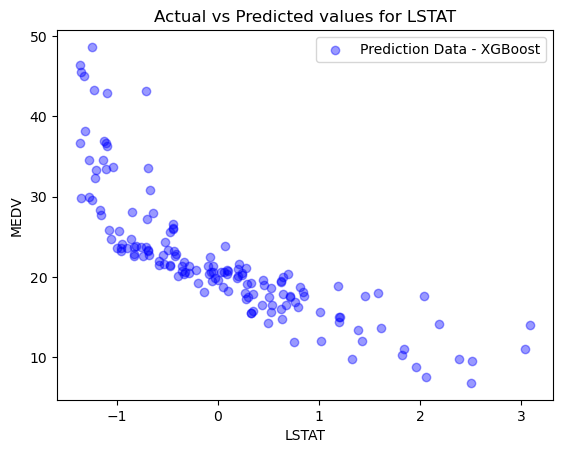

In [39]:
# Plot XGBoost predictions
xgb_y_pred = xgb_model.predict(X_test.sort_values(by=col))
plt.scatter(X_test[col].sort_values(), xgb_y_pred, color='blue', alpha=0.4, label='Prediction Data - XGBoost')

plt.xlabel(col)
plt.ylabel('MEDV')
plt.legend()
plt.title(f'Actual vs Predicted values for {col}')
plt.show()

In [40]:
# Feature Importance
feature_imp = []
for model_name, model_instance in {'RandomForestRegressor': best_random_forest, 'XGBRegressor': xgb_model}.items():
    try:
        importances = model_instance.feature_importances_
        print(f"Number of chosen_cols for {model_name}: {len(chosen_cols)}")
        print(f"Number of importances for {model_name}: {len(importances)}")
        feature_imp.append(pd.Series(importances, index=chosen_cols, name=model_name))
    except AttributeError:
        pass
    
feature_imp_df = pd.concat(feature_imp, axis=1).sort_values(by='XGBRegressor', ascending=False)
print("\nFeature Importance:")
print(feature_imp_df)

Number of chosen_cols for RandomForestRegressor: 13
Number of importances for RandomForestRegressor: 13
Number of chosen_cols for XGBRegressor: 13
Number of importances for XGBRegressor: 13

Feature Importance:
         RandomForestRegressor  XGBRegressor
RM                    0.377420      0.412302
LSTAT                 0.335707      0.293833
CRIM                  0.076413      0.071746
NOX                   0.050184      0.044925
PTRATIO               0.034636      0.038701
AGE                   0.029648      0.024786
RAD_TAX               0.010104      0.023174
TAX                   0.016865      0.021971
INDUS                 0.033672      0.019251
B                     0.018294      0.016685
CRIM_ZN               0.007505      0.013488
RAD                   0.006171      0.013011
ZN                    0.003381      0.006127
